## Ultimate challenge

In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

## Part 1 - Exploratory data analysis

### Task 1 - Aggregate login counts based on 15-min time interval

### Data Pre-processing

Breaking down pre-processing tasks:
1. Convert the object into datetime format
2. Create a new column storing the time span between each instance and the previous one (time_span)
3. Use pandas Grouper function to aggregate the time at 15 mn intervals

In [2]:
# Opening the logins file
with open('logins.json') as f:
    time = json.load(f)

In [3]:
# Transforming the data into a dataframe and visualizing the first 5 rows
time = pd.DataFrame(time)
time.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Checking the type of values in login_time and size of our data
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [5]:
# 1. Converting the object into datetime format
time['login_time'] = pd.to_datetime(time['login_time'])

In [6]:
# 2. Creating a list to store all the time span differences
# this will calculate all the values from the 2nd value to the last

duration = []
for i in range(len(time) -1):
    span = time.iloc[i+1] - time.iloc[i]
    duration.append(span)

In [7]:
# Checking the data
duration[2]

login_time   -1 days +23:59:59
dtype: timedelta64[ns]

In [8]:
# Checking the len of the duration to confirm is effectively missing 1 value
len(duration)

93141

In [9]:
# Adding the first element to the list that was ommitted previously
duration.insert(0,0)

# Checkling again that the len of duration is equal to the len of the dataframe
len(duration)


93142

In [10]:
# Adding the duration as a new column to our time dataframe
time['time_span'] = duration

In [11]:
# Checking data
time.head()

,login_time,time_span
0,1970-01-01 20:13:18,0
1,1970-01-01 20:16:10,login_time 0 days 00:02:52 dtype: timedelta6...
2,1970-01-01 20:16:37,login_time 0 days 00:00:27 dtype: timedelta6...
3,1970-01-01 20:16:36,login_time -1 days +23:59:59 dtype: timedelt...
4,1970-01-01 20:26:21,login_time 0 days 00:09:45 dtype: timedelta6...


In [12]:
# 3. Using Grouper function to aggregate the data. 
# For the function to work, the data frame index has to converted in timeindex

time = time.set_index('login_time')
time_series = time.time_span.groupby(pd.Grouper(freq = '15min')).count()

In [13]:
# Converting the time_series into dataframe
time_series = pd.DataFrame(time_series)

In [14]:
data = time_series.reset_index()

In [15]:
data['hour'] =data['login_time'].dt.hour
data['day'] =data['login_time'].dt.weekday

In [16]:
data

,login_time,time_span,hour,day
0,1970-01-01 20:00:00,2,20,3
1,1970-01-01 20:15:00,6,20,3
2,1970-01-01 20:30:00,9,20,3
3,1970-01-01 20:45:00,7,20,3
4,1970-01-01 21:00:00,1,21,3
...,...,...,...,...
9783,1970-04-13 17:45:00,5,17,0
9784,1970-04-13 18:00:00,5,18,0
9785,1970-04-13 18:15:00,2,18,0
9786,1970-04-13 18:30:00,7,18,0


### Visualizations

We will create 3 visualization
1. login_time time series 
2. Daily trend
3. Monthly trend

In [17]:
# aggregating data prior to visualization
data_hourly = data.groupby(by = 'hour').agg({'time_span': ['sum']})
data_daily = data.groupby(by = 'day').agg({'time_span': ['sum']})

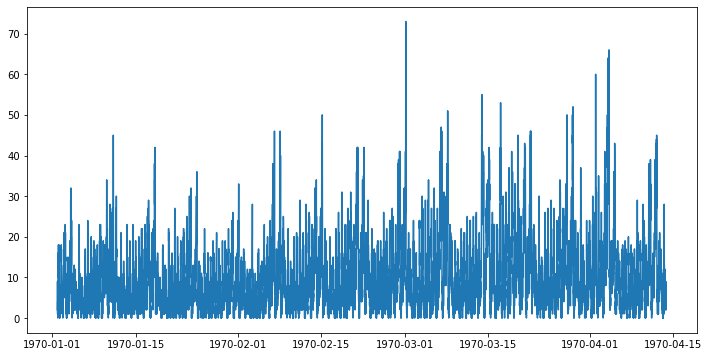

In [18]:
# 1. Visualizing time series
plt.figure(figsize = (12,6))
plt.plot(data.login_time, data.time_span)

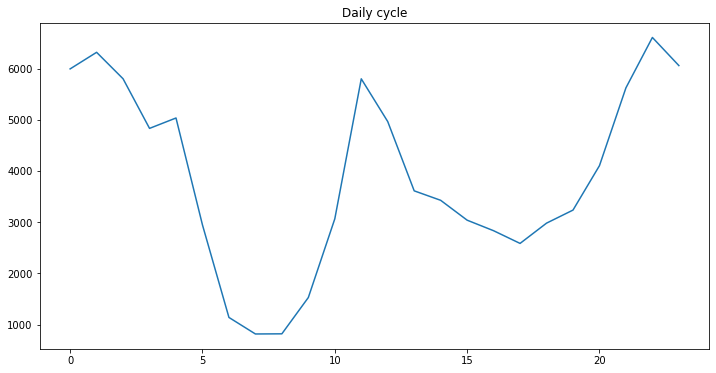

In [19]:
# 2. Visualizing Daily trends
plt.figure(figsize = (12,6))
plt.plot(data_hourly)
plt.title('Daily cycle')
plt.show()

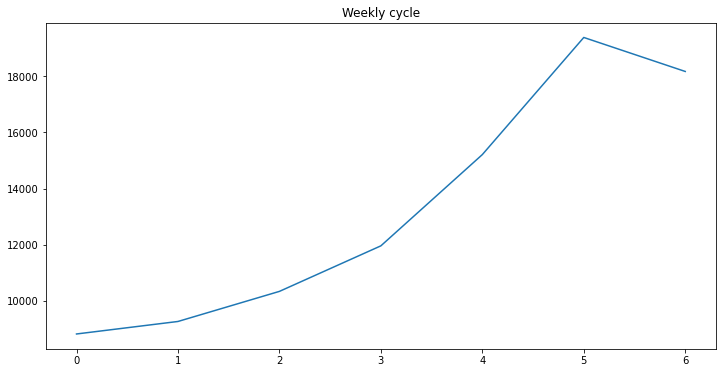

In [20]:
# 3. Visualizing Monthly trends
plt.figure(figsize = (12,6))
plt.plot(data_daily)
plt.title('Weekly cycle')
plt.show()

**Findings**
- We notice several peaks during the day: 4 am to 8 am, 5pm and 10 pm till midnight where the number of users login into the platform
- Also there is a clear peak of interactions during the week end as opposed to the rest of the week.

## Part2 - Experiment and metrics design

**Assumptions from the brief:**
- Gotham is more active at night
- Metropolis is more active during the day
- Because of the toll cost, drivers from both cities are exclusive to the city
- There is an incentive to cover the tool cost to push drivers to accept rides from both cities

**1. Metric** \
By making Gotham drivers covering Metropolis at night and Metropolis drivers covering Gotham during the day the business can make more revenue.

Revenue is translated by increased number of rides during the day in Gotham during the night in Metropolis

If the experiment is successful, the business should see a growth in the total number of rides in both cities directly coming from the specified timing in the 2 cities. Hence the metric is increase in total number of rides

**2. Experiment description**

- Step 0: Define the metric to be tested
    - Metric has been defined above (increased in number of rides), we assume no other factor influences the choice of drivers not to target the other city
    
- Step 1: Setting groups
    - Drivers are split into test and control groups respectively A and B. Both groups includes drivers from both cities
    - Group A receives the incentive, group B do not receives the incentive

- Step 2: Defining hypothesis
    - Null hypothesis (status quo) Ho: Number of rides in group A = Number of rides in group B
    - Alternative hypothesis Ha: Number of rides in group A > Number of rides in group B

    
- Step 3: Execute the test
    - Define the right period, ideally, the larger the sample, the better to ensure normality of the test results
    - Set significance level usually 95%
    
- Step 4: Test for normality and homogeneity of the test result to inform the type of test to use
    - If Normality and homogeneity, use t-test, if normality only, use Welch Test
    - Else, use Mann-Whitney U Test
    
    
- Step5: Derive conclusions
    - Base on the test results, calculate the p value and check if signifant enough to reject or fail to reject the null hypothesis   


## Part 3 - Predictive modelling

### Loading the ultimate data challenge and converting data into a dataframe

In [21]:
# loading the ultimate data challenge file
with open('ultimate_data_challenge.json') as f2:
    operations = json.load(f2)

In [22]:
operations = pd.DataFrame(operations)

In [23]:
operations.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### Checking data quality

In [24]:
# Checking type of columns
operations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [25]:
# Checking null values
operations.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [26]:
operations.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [27]:
operations.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

### Checking outliers

<AxesSubplot:xlabel='trips_in_first_30_days'>

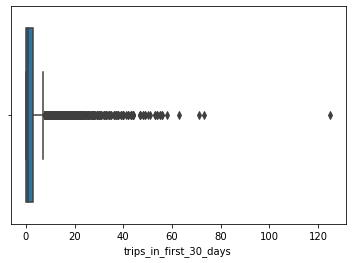

In [28]:
sns.boxplot(x= operations['trips_in_first_30_days'])

<AxesSubplot:xlabel='avg_surge'>

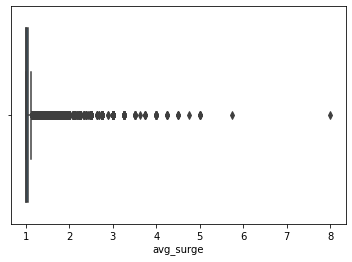

In [29]:
sns.boxplot(x= operations['avg_surge'])

<AxesSubplot:xlabel='weekday_pct'>

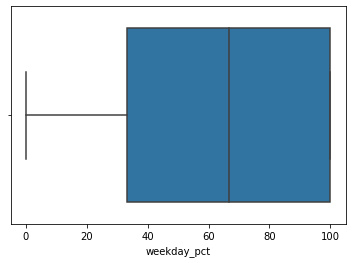

In [30]:
sns.boxplot(x= operations['weekday_pct'])

There are 3 columns with missing data: avg_rating_of_driver, phone and avg_rating_by_driver
Datetime columns (signup_date and last_trip_date) are object format instead of  datetime

### Explorative Data Analysis

#### How many customers are currently active?

In [31]:
from datetime import datetime

def days_since_last_trip(array, date):
    days_list = []
    array = pd.to_datetime(array)
    date_object = datetime.strptime(date, '%Y-%m-%d')
    for i in array:
        days = date_object - i
        days_list.append(days.days)
    days_df = pd.DataFrame(days_list)
    return days_df    
        

In [32]:
reference =  max(operations.last_trip_date)
retained = days_since_last_trip(operations.last_trip_date, reference)

In [33]:
retained = retained.rename(columns = {0:'days'})

In [34]:
active = retained.loc[retained['days'] >= 30].count()/len(retained)
print('There are {} of customers active at this time'.format(active))

There are days    0.6338
dtype: float64 of customers active at this time


In [35]:
retained['status'] = np.where(retained['days'] >= 30, True, False)
retained

,days,status
0,14,False
1,57,True
2,175,True
3,2,False
4,108,True
...,...,...
49995,26,False
49996,157,True
49997,40,True
49998,167,True


In [36]:
retained['duration'] = days_since_last_trip(operations.signup_date, reference)
retained

,days,status,duration
0,14,False,157
1,57,True,153
2,175,True,176
3,2,False,172
4,108,True,155
...,...,...,...
49995,26,False,157
49996,157,True,158
49997,40,True,151
49998,167,True,168


Before pursuing others EDA steps, we will merge both retained and operations dataframes into a single dataset

In [37]:
# Merging both dataframes
operations['days'] = retained['days']
operations['status'] = retained['status']
operations['duration'] = retained['duration']

### Distribution Analysis

In [38]:
# Getting statistics of our features
operations.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,days,duration
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000,50000.00000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,72.665220,165.45532
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,61.718985,8.75422
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,151.00000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,13.000000,158.00000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,54.000000,165.00000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,137.000000,173.00000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,181.000000,181.00000


<AxesSubplot:>

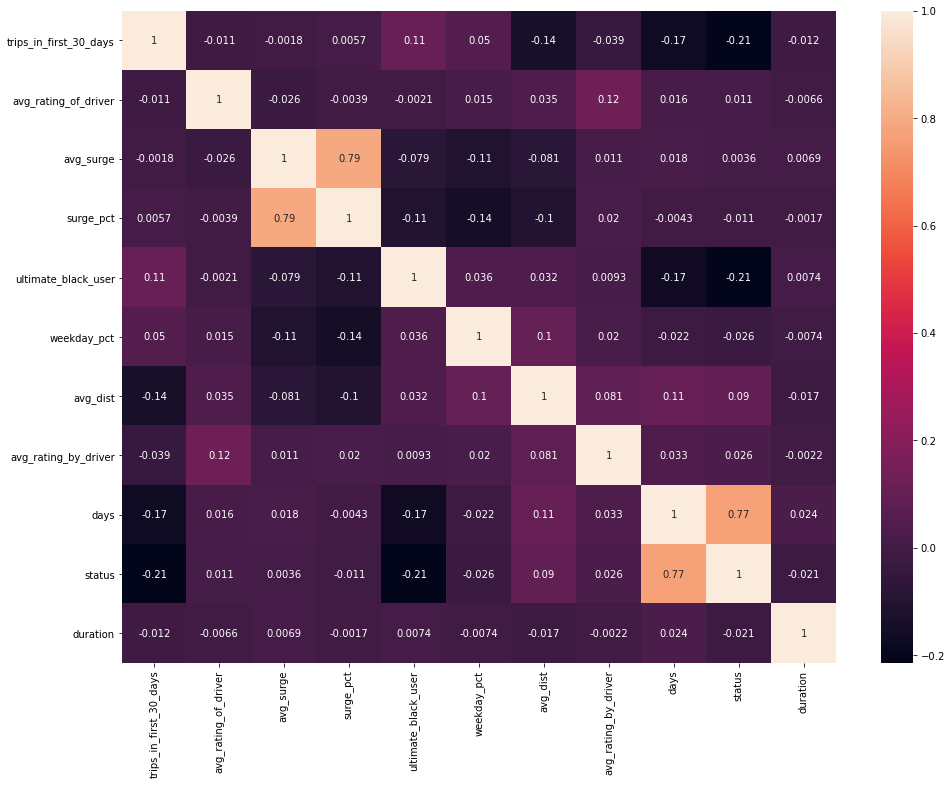

In [39]:
# plotting the heatmap to assess the correlation between features
plt.figure(figsize = (16,12))
sns.heatmap(operations.corr(), annot = True)

In [51]:
retention_6m = operations.loc[operations['duration'] >= 180]

<AxesSubplot:>

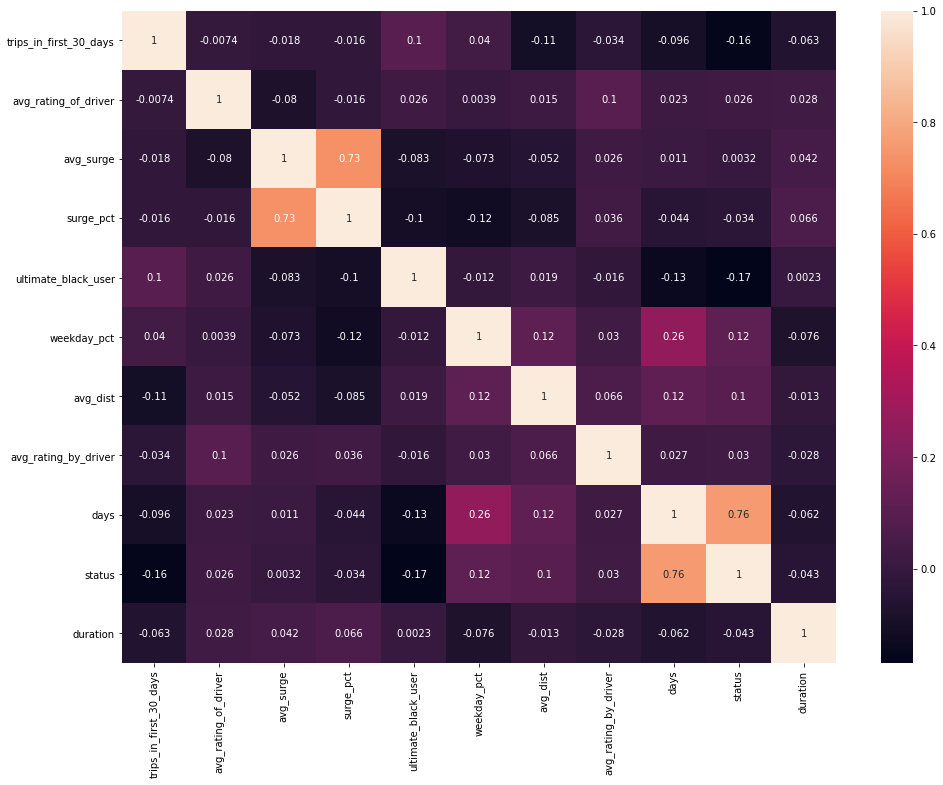

In [52]:
plt.figure(figsize = (16,12))
sns.heatmap(retention_6m.corr(), annot = True)

In [56]:
retention_6m = operations.loc[operations['duration'] >= 180]
len(retention_6m.status)/len(operations.status)

0.05482

We assessed strenght of correlation between all features and our target label (status) using the 3 matrices above:

**1st matrix (no filter)**
- Features positvely correlated to 'status': distance, days (number of days since sign up)
- Features negatively correlated to 'status': trips in first 30 days, ultimate black user

**2nd matrix (filtered only who signed up 6 months ago)**
- weekday_pct suddently becomes a significantly positve factor. We also observe it has a strong correlation with the days since last login
- As time pass by trips in first 30 days and ultimate black users tend to reduce in importance while avg-distance becomes more influent

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


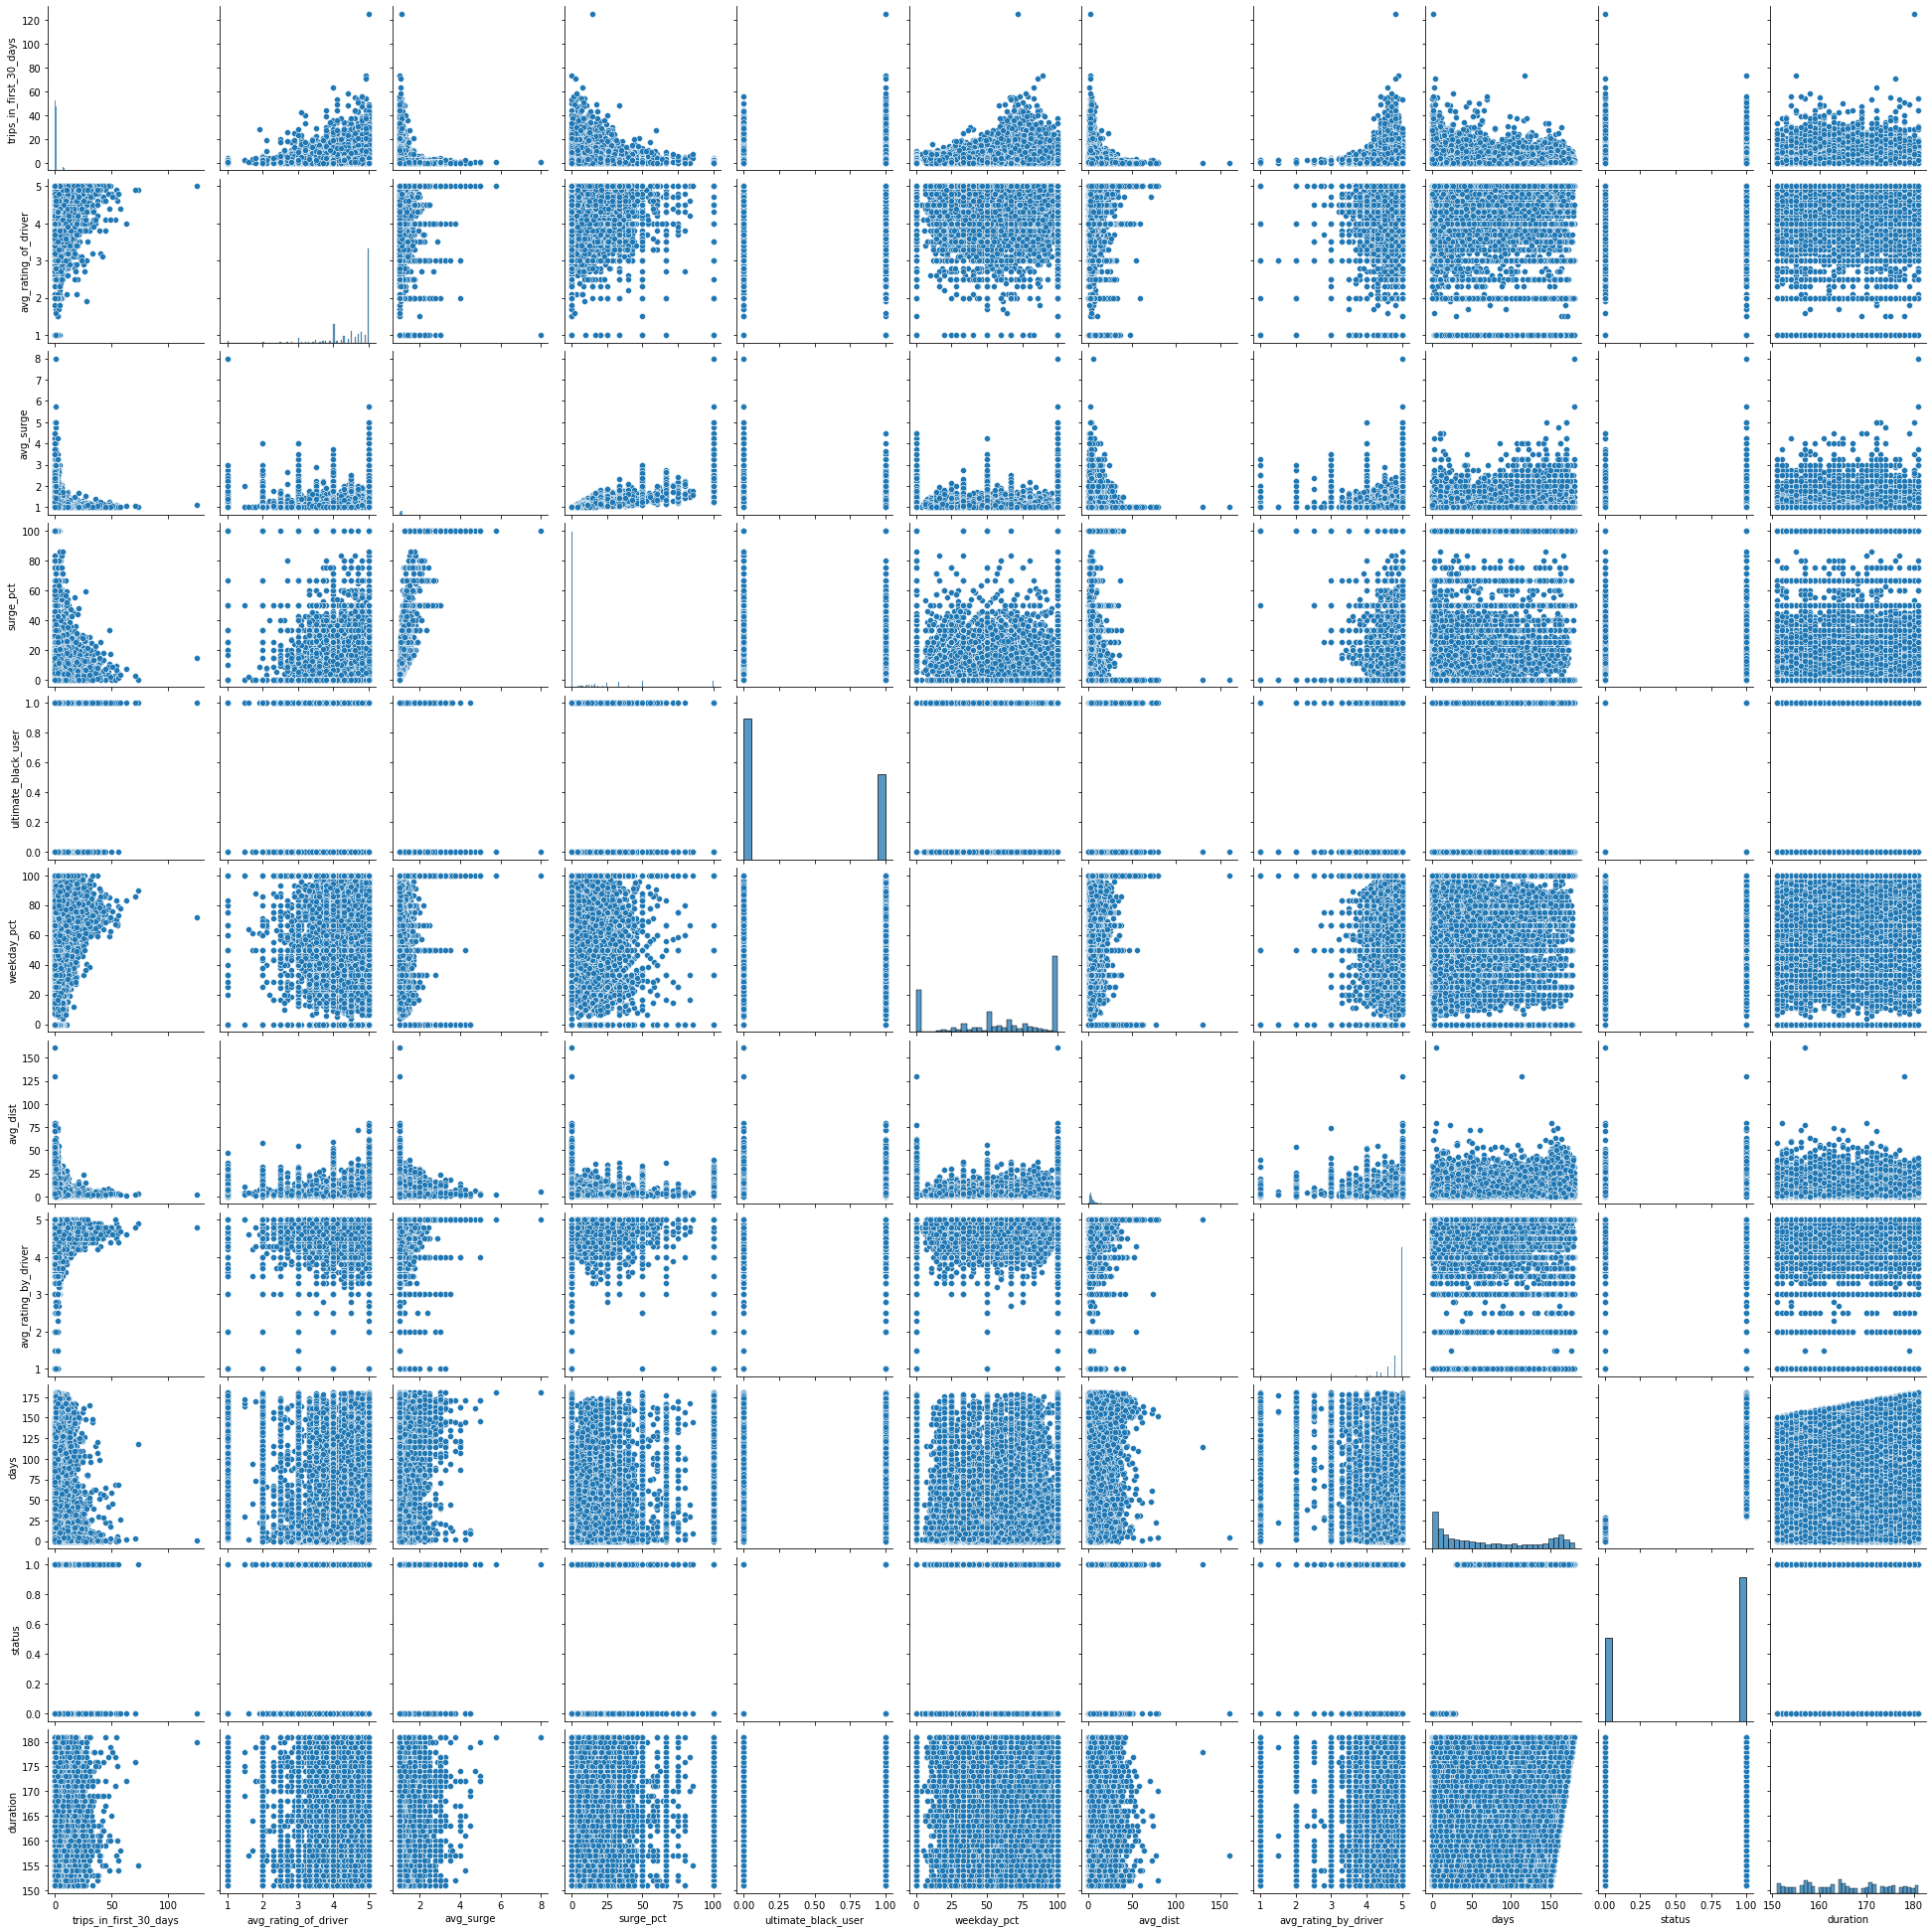

In [40]:
sns.pairplot(operations)

### Imputing missing values

In [41]:
df = operations
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())

In [42]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())

In [43]:
df['phone'] = df['phone'].fillna(df['phone'].mode()[0])

In [44]:
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
days                      0
status                    0
duration                  0
dtype: int64

### Transforming categorical data

In [45]:
# Finalizing our dataframe by converting categorical data into numeric 
# and correcting the type of datetime values
df = pd.get_dummies(operations, columns = ['city', 'phone', 'ultimate_black_user', 'status'], drop_first = True)
df['signup_date'] =  pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

Few columns seems to be directly correlating with status_True (active users): trips in first 30 days, city, phone and ultimate black user
surge and ratings doesnt seems to impact much the likelihood of been active or not
Since the task is to build a predictive model to help Ultimate determine wether or not a user will be active, we will be using a supervise machine learning approach to predict labels in this case the 'status'. All others columns will be the features
Classification issue: determine if a user is active or not

In [46]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,days,duration,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True,status_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,14,157,1,0,1,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,57,153,0,0,0,0,1
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,175,176,0,0,1,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,2,172,1,0,1,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,108,155,0,1,0,0,1


### Modelling

In [61]:
trimmed_df = df.loc[df['duration'] >= 180]
trimmed_df.shape

(2741, 16)

In [62]:
# Defining features and labels

X = trimmed_df.drop(['status_True', 'signup_date', 'last_trip_date'], axis = 1)
y = trimmed_df['status_True']

In [63]:
# Split data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#### KNN model

In [64]:
param_grid = {'n_neighbors':np.arange(3,10)}
knn_model = KNeighborsClassifier()
knn_cv = GridSearchCV(knn_model, param_grid, cv = 5)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([3, 4, 5, 6, 7, 8, 9])})

In [65]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9868613138686133
Best Parameters: {'n_neighbors': 5}


In [66]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [67]:
from math import sqrt
y_pred = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred)
rmse_knn = sqrt(mse_knn)
print(mse_knn, rmse_knn)

0.013119533527696793 0.11454053224818188


### Conclusions and recommendations

**KEY FINDINGS**
- Only 64% of users are currently active and as time passes by they are more likely to stay inactive
- Activating their account by taking a ride during the first 30 days is a critical factor to predict their engagement
- Additional factors worth considering are:
- When they use rides primarily during the weekday, they are more likely to stay active. Probably in this case they use it for work on a regular basis
- Premium users (activating ultimate black) tend to be less frequent customers, hence are less likely to be active
- Average distance matters. Probably for users are more inclined to take rides for shorter distaces than longer ones

**PREDICTIONS**
- Understanding earlier if a customer is likely to stay active or not will lead to actions that may increase their engagement
- We used KNN model to predict likelihood to retain a user over a period of 6 months.
- Our solution is robust with a mean squared error of 0.013 and root mean squared error of 0.11.
- Choice for this algorithm was made considering few factor:
    - Type of issue at hand: classification (predict wether or not a user will be active)
    - Noise in Data: as we could see from the boxplot, we had a lot of outliers and KNN algorithm is robust to noise in data
    - Sample size: since we restricted predictions sample to those having signed up since 6 months our data rows reduced from 5000 to 2741 which is a small size 
    - However, the limitation of this model is the uncertaintly around the number of k(neighbors). But we mitigated this through by using GridSearch CrossValidation determine the best k over a given range.
    - Limited dimension: we only have 15 features to consider

As alternative, we could have used a random forest which presumably could have performed as good as the KNN and better handle categorical data (hence one hot encoder wouldnt have been required).

**RECOMMENDATIONS**
- Focus marketing efforts to incentivize customers to activate their account within 30 days of sign off
- Encourage infrequent users to consider Ultimate rides during workweek
- Also encourage Ultimate Black users to consider using others modules, not just premeium

**FURTHER WORK**
To immprove our modelling, it could have been interesting to segment customer first as from moment of sign up to have more personalized targeting strategies.